# ST2195 Programming for Data Science Coursework
#### Done by: Sebastian Tock Shao Xuan
#### Student ID: 210502989

In this file, we are going to perform data analysis on the Airline on-time data from the 2009 ASA Statistical Computing and Graphics Data Expo, the data consists of flight arrival and departure details for all commercial flights on major carriers within the USA, between October 1987 and April 2008. This is a very large dataset, therefore we have only selected a subset of consecutive years ranging from 2006 to 2007, the analysis is supported by relevant supplementary data available in the data expo.

Included in this file, will be the steps taken starting from the extraction of the raw data up to the answer for each question. Before we begin the analysis it needs to be noted that there will be 3 .csv files in total that will be used in this analysis (2006.csv, 2007.csv and plane-data.csv). The .csv files can be downloaded from the Harvard Dataverse at https://doi.org/10.7910/DVN/HG7NV7

Through this analysis we are going to answer the following questions:

1. When is the best time of day, day of the week, and time of the year to fly to minimize delays?
2. Do older planes suffer more delays?
3. How does the number of people flying between different locations change over time?
4. Can you detect cascading failures as delays in one airport create delays in others?
5. Use the available variables to construct a model that predicts delays.

## Pre-Analysis Preparations

### Required libraries

The following are the required libraries needed to run this file, If you are missing any of the packages please install them using `python -m pip install <package>` in the terminal

In [1]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # Removes Warning of chained assignment
import numpy as np
import scipy.stats
import datetime as datetime
from datetime import date, timedelta
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix

After loading the required libraries we are going to load in the .csv files. Please ensure this file is in the same folder as the .csv files for this to work.

### Loading in Data set

Before any analysis can be done we will need to extract the data from the .csv files into data frames that we can manipulate in python, please ensure this file is in the same folder as the .csv files for it to work.

The plane-data.csv file will be loaded into the 'planes' data frame

In [2]:
# ======= create dataframes =======

# Load in relavant data from .csv files
## loading in planes data from .csv file
planes = pd.read_csv("plane-data.csv")

To extract the plane-data.csv, we only need to use the `pd.read_csv()` function to load the .csv file into the planes data frame.

In [3]:
# ======= create dataframes =======

## loading in data to form ontime table
### A subset of 2 years ranging from 2006 to 2007 is selected for my analysis
ontime = pd.concat([pd.read_csv(str(f)+".csv") for f in range(2006,2008)])

To extract the 2006.csv and 2007.csv files, we will only need to pass the `pd.read_csv()` function through a `for-loop` to loop through the selected years and using to `pd.concat()` to append the years consecutively into ontime. 

#### Looking at how the data frames have been structured

After loading in the data into data frames, we will have to look through the data frame for any errors or corrupted data, and perform any data cleaning that is needed. This needs to be done as the insights provided by the analysis is only as good as the data we feed it, therefore, to ensure an accurate and insightful analysis we will have to “clean” the data.

#### ontime data frame

In [4]:
# Looking into the data structure of ontime
ontime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14595137 entries, 0 to 7453214
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             int64  
 20  TaxiOut            int64  
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       int64  
 25  WeatherDelay     

Using the `.info()` function we can take a look at how ontime has been structured. We can see that there are 14,595,137 entries and 29 columns, this is a relatively large data set so it is impossible to look through it in its entirety to look for errors.

Preliminary observations from looking at the data structure of ontime, we can see that the date values are separated into 3 columns namely Year, Month and DayofMonth, and these attributes have been formatted as int data type.

In [5]:
# Counting the number of null values in each column
ontime.isnull().sum()

Year                        0
Month                       0
DayofMonth                  0
DayOfWeek                   0
DepTime                282682
CRSDepTime                  0
ArrTime                316047
CRSArrTime                  0
UniqueCarrier               0
FlightNum                   0
TailNum                    22
ActualElapsedTime      316047
CRSElapsedTime            998
AirTime                316047
ArrDelay               316047
DepDelay               282682
Origin                      0
Dest                        0
Distance                    0
TaxiIn                      0
TaxiOut                     0
Cancelled                   0
CancellationCode     14312454
Diverted                    0
CarrierDelay                0
WeatherDelay                0
NASDelay                    0
SecurityDelay               0
LateAircraftDelay           0
dtype: int64

Using `.isnull()` function to return a Boolean value on whether there is null values or not, and then using `.sum()` to return the total number of null values in each column.

Now that we know the existence of null values, we will have to remove them to prevent them from affecting the analysis.

After eyeballing ontime as a table, we noticed that the “NaN” values only appear whenever there is Cancelled or Diverted Flights.

#### Cleaning the ontime data frame

In [6]:
# ======= Cleaning Data ============
# From ontime table
# Filtering out diverted and cancelled flights
ontime = ontime.query("Cancelled == 0 & Diverted == 0") # Looking at completed flights for this analysis

# Creating date column
ontime['date'] = ontime.apply(lambda x: datetime.date(x['Year'], x['Month'], x['DayofMonth']), axis=1)
ontime['date'] = pd.to_datetime(ontime['date'])

To solve the issue of the date values in the ontime data frame, we applied a `lambda` function based on the `datetime.date()` function using `.apply()` to combine the Year, Month and DayofMonth columns to create the date column in the correct `datetime` data type. 

The removal of the “NaN” values in ontime is then filtered out using `.query()`. By filtering out the cancelled and diverted flights, we will only be looking at the completed flights, this does not interfere with our analysis as the questions are mostly based around delays.

#### Cleaned ontime data frame

In [7]:
# Looking into the data structure of the cleaned ontime
ontime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14279090 entries, 0 to 7453214
Data columns (total 30 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Year               int64         
 1   Month              int64         
 2   DayofMonth         int64         
 3   DayOfWeek          int64         
 4   DepTime            float64       
 5   CRSDepTime         int64         
 6   ArrTime            float64       
 7   CRSArrTime         int64         
 8   UniqueCarrier      object        
 9   FlightNum          int64         
 10  TailNum            object        
 11  ActualElapsedTime  float64       
 12  CRSElapsedTime     float64       
 13  AirTime            float64       
 14  ArrDelay           float64       
 15  DepDelay           float64       
 16  Origin             object        
 17  Dest               object        
 18  Distance           int64         
 19  TaxiIn             int64         
 20  TaxiOut            int6

Looking at the cleaned ontime data frame, we can see that the number of entries went down to 14,279,090 but an increase of columns to 30. The new column is namely the Date attribute formatted as a `datetime` data type.

In [8]:
# Counting the number of null values in each column
ontime.isnull().sum()

Year                        0
Month                       0
DayofMonth                  0
DayOfWeek                   0
DepTime                     0
CRSDepTime                  0
ArrTime                     0
CRSArrTime                  0
UniqueCarrier               0
FlightNum                   0
TailNum                     0
ActualElapsedTime           0
CRSElapsedTime              0
AirTime                     0
ArrDelay                    0
DepDelay                    0
Origin                      0
Dest                        0
Distance                    0
TaxiIn                      0
TaxiOut                     0
Cancelled                   0
CancellationCode     14279089
Diverted                    0
CarrierDelay                0
WeatherDelay                0
NASDelay                    0
SecurityDelay               0
LateAircraftDelay           0
date                        0
dtype: int64

Looking at the output above, we can see that there is no more null values apart for CancellationCode column, and since the CancellationCode does not affect our analysis, we can ignore this.

With this we are done cleaning the ontime data frame.

#### planes data data frame

In [9]:
# Looking into the data structure of planes
planes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5029 entries, 0 to 5028
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tailnum        5029 non-null   object
 1   type           4480 non-null   object
 2   manufacturer   4480 non-null   object
 3   issue_date     4480 non-null   object
 4   model          4480 non-null   object
 5   status         4480 non-null   object
 6   aircraft_type  4480 non-null   object
 7   engine_type    4480 non-null   object
 8   year           4480 non-null   object
dtypes: object(9)
memory usage: 353.7+ KB


Looking at the structure of the planes data frame, we can see that there is 5,029 entries with 9 columns, this is a smaller data frame as compared the ontime data frame. But looking through it all for errors is still a needless task.

Preliminary observations from looking at the data structure of planes, we noticed that issue_date is formatted as a chr data type.

By eyeballing through planes as a table, we noticed that there are some rows that contain “ ” values.

In [10]:
# Counting the number of null values in each column
planes.isnull().sum()

tailnum            0
type             549
manufacturer     549
issue_date       549
model            549
status           549
aircraft_type    549
engine_type      549
year             549
dtype: int64

We can see from the output above that there is 549 rows with null values.

#### Cleaning the planes data frame

In [11]:
# ======= Cleaning Data ============
# From plane table
# Formating issue_date into str to remove NaN Values
planes[['Month', 'Day', 'Year']] = planes['issue_date'].astype('str').str.split('/', expand = True)
planes = planes.dropna() # Dropping rows with NA values

# Creating issue_date column
planes['issue_date'] = pd.to_datetime(planes[['Year', 'Month', 'Day']])

To resolve the issues in the planes data frame, we converted issue_date into a string using `astype('str')` then separated it using `.str.split()`  on the separator “/” in to Month, Day and Year columns, the rationale behind this is that it causes the rows with blank values to return “NaN” since they do not contain “/”, we then remove the “NaN” values using `.dropna()`. We have to do this in such a convoluted way as the blank values have proven itself stubborn against usual ways of removing them. Issue_date is then recreated using `pd.to_datetime()`,this function formats issue_date as a `datetime` data type automatically.

#### Cleaned planes data frame

In [12]:
# Looking into the data structure of planes
planes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4479 entries, 34 to 5028
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tailnum        4479 non-null   object        
 1   type           4479 non-null   object        
 2   manufacturer   4479 non-null   object        
 3   issue_date     4479 non-null   datetime64[ns]
 4   model          4479 non-null   object        
 5   status         4479 non-null   object        
 6   aircraft_type  4479 non-null   object        
 7   engine_type    4479 non-null   object        
 8   year           4479 non-null   object        
 9   Month          4479 non-null   object        
 10  Day            4479 non-null   object        
 11  Year           4479 non-null   object        
dtypes: datetime64[ns](1), object(11)
memory usage: 454.9+ KB


We can see that from the structure of the cleaned planes data frame, the entries dropped to 4479 with an increase to 12 columns. We can now see issue_date in the correct Date data type.

In [13]:
# Counting the number of null values in each column
planes.isnull().sum()

tailnum          0
type             0
manufacturer     0
issue_date       0
model            0
status           0
aircraft_type    0
engine_type      0
year             0
Month            0
Day              0
Year             0
dtype: int64

From the output above we can see that we successfully removed all null values from the dataframe. With this we are done cleaning the planes table.

## Data Analysis

### Question 1

#### When is the best time of day, day of the week, and time of year to fly to minimize delays?

To answer this question, we decided to categorize the Month attribute as seasons to represent time of the year, CRSDepTime attribute as the various time of day and the DayofWeek attribute as the day of the week. We will be selecting Arrival Delays (ArrDelay) as the indicator of delay as flights can depart late and still arrive early or on time, so from the perspective of the passenger, arrival delays will impact their travel plans more.

In [14]:
# ===== Forming the Delays table for analysis ======

# Delays Table
Delays = ontime

# Time of Year will be represented by Seasons.
def find_Season(Month):
    Season_month = {
            12:'Winter', 1:'Winter', 2:'Winter',
            3:'Spring', 4:'Spring', 5:'Spring',
            6:'Summer', 7:'Summer', 8:'Summer',
            9:'Autumn', 10:'Autumn', 11:'Autumn'}
    return Season_month.get(Month)

Season_List = []

for Month in Delays['Month']:
    season = find_Season(Month)
    Season_List.append(season)
    
Delays['Season'] = Season_List

# A time frame of 4 hours is selected for time of day
def find_time(CRSDepTime):
    if CRSDepTime in range(500,1200):
        return "Morning"
    elif CRSDepTime in range(1200, 1700):
        return "Afternoon"
    elif CRSDepTime in range(1700, 2100):
        return "Evening"
    else:
        return "Night"
    
TimeofDay_list =[]

for CRSDepTime in Delays['CRSDepTime']:
    TimeofDay = find_time(CRSDepTime)
    TimeofDay_list.append(TimeofDay)

Delays['TimeofDay'] = TimeofDay_list

# Day of Week Function
def find_day(DayOfWeek):
    Day = {
        1:'Monday', 2:'Tuesday', 3:'Wednesday',
        4:'Thursday', 5:'Friday', 6:'Saturday',
        7:'Sunday'}
    return Day.get(DayOfWeek)

Day_list = []

for DayOfWeek in Delays['DayOfWeek']:
    Day = find_day(DayOfWeek)
    Day_list.append(Day)

Delays['Day'] = Day_list

# Finding out which flights has DepDelays
def delayed(ArrDelay):
    if ArrDelay > 0:
        return 1
    else:
        return 0
        
Delayed_list = []

for ArrDelay in Delays['ArrDelay']:
    Delay = delayed(ArrDelay)
    Delayed_list.append(Delay)
    
Delays['Delayed'] = Delayed_list

We created the Delays table from the ontime data frame. We did not use `.copy()` here as we wanted the changes we made to be passed on to the ontime data frame as well.

We then create new columns by defining functions such as the `find_season(month)` function where we specified that the numeric values will be converted to their respective seasons, we then used a `for-loop` to loop through the entire Month column in the Delays table to return a 'season' value to be added to a list, we then pass the list into a new column in Delays named 'Season'.

The `find_time(CRSDepTime)` function is defined in such a way that it goes through a `if-elif-else` statement that returns “Morning” when CRSDepTime is between 500 and 1200, “Afternoon” when CRSDepTime is between 1200 and 1700, “Evening” when CRSDepTime is between 1700 and 2100, and "Night" for the rest of the values this is based on the logic that if time of day is not “Morning” or “Afternoon” or “Evening” it has to be “Night”. We then pass the function into a `for-loop` to loop through the entire CRSDepTime column in the Delays table to add a 'Time' value to a list, the list is then passed into a new column in Delays named 'TimeofDay'.

The `find_day(DayofWeek)` function is defined in such a way that the numeric values will return the corresponding day in word form, we then use a `for-loop` to loop through the entire DayofWeek column in the Delays table to add a 'Day' value to a list, the list is then passed into a new column in Delays named 'Day'.

The `delayed(ArrDelay)` function is defined in such a way that it uses a `if-else` statement to return a 1 when ArrDelay is greater than 0 otherwise return a 0 when it is not. We then use a `for-loop` to loop through the entire ArrDelay column in the Delays table to add a 'Delayed' value to a list, the list is then passed into a new column in Delays named "Delayed"

#### Delays table

In [15]:
# ========== Deriving Percentage of Delay and Average Arrival Delay ==============
# Grouping the data by Season, Day and Time of Day
Delays = Delays.groupby(['Season', 'Day', 'TimeofDay'], as_index = False).agg({'Delayed': ['size', 'sum'], 'ArrDelay': ['mean']})

# Calculating ProbabilityofDelay
Delays['PercentageDelay'] = Delays[('Delayed', 'sum')]/ Delays[('Delayed', 'size')] * 100

Delays['AvgDelay'] = Delays[('ArrDelay', 'mean')]

Delays = Delays[['Season', 'Day', 'TimeofDay', 'PercentageDelay', 'AvgDelay']]

Delays.sort_values(by = ['PercentageDelay'])

,Season,Day,TimeofDay,PercentageDelay,AvgDelay
,,,,,
11,Autumn,Saturday,Night,31.541610,-1.395471
14,Autumn,Sunday,Morning,32.228418,-0.591528
9,Autumn,Saturday,Evening,33.123461,0.953336
42,Spring,Sunday,Morning,33.561409,0.196210
10,Autumn,Saturday,Morning,34.478263,0.805699
...,...,...,...,...,...
59,Summer,Friday,Night,61.800230,21.335634
75,Summer,Thursday,Night,63.423885,24.174566
85,Winter,Friday,Evening,63.710621,24.079025


We then group the Delays table by Season, Day and TimeofDay using the function `.groupby()`, then use the `.agg()` function inconjuction to derive the size and sum of the Delayed column as well as the mean of ArrDelay.

The Percentage of Arrival Delay (PercentageDelay) is then calculated using the size and sum of the Delayed column, we renamed the mean of ArrDelay into AvgDelay.

#### Visualizing the Delays Table
We decided to create a connected scatter of the Flights table to visualize the results of the analysis of ArrDelay with respect to time.

We decided to use the `plotnine` library here to mimic the `ggplot` library to replicate the plots made in R.

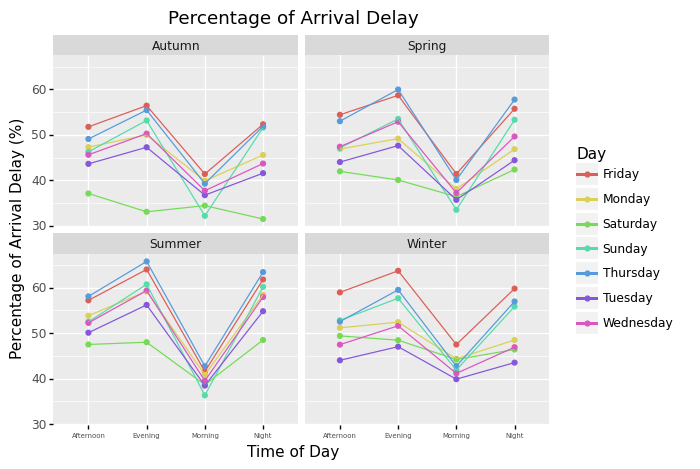

<ggplot: (8776937212426)>

In [16]:
# Using plotnine library to mimic ggplot
(
    ggplot(Delays, aes(x = 'TimeofDay', y = 'PercentageDelay', group = 'Day', colour = 'Day'))
    + geom_point()
    + geom_line()
    + facet_wrap('Season')
    + labs(y ='Percentage of Arrival Delay (%)', x = 'Time of Day')
    + theme(axis_text_x = element_text(size = 5))
    + ggtitle("Percentage of Arrival Delay")
)

From the plot of Percentage of Arrival Delay, we can see that in general Autumn has the lowest percentage of arrival delay as it hits a maximum of around 56% and a minimum of around 31%. we can also see that the shape of the plot is generally the same with the exception of the lines of Saturday causing some variation in the plots.

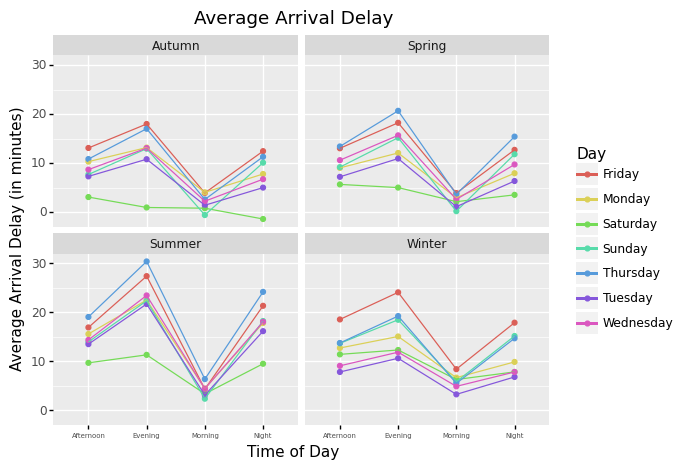

<ggplot: (8777506111187)>

In [17]:
# Using plotnine library to mimic ggplot
(
    ggplot(Delays, aes(x = 'TimeofDay', y = 'AvgDelay', group = 'Day', colour = 'Day'))
    + geom_point()
    + geom_line()
    + facet_wrap('Season')
    + labs(y ='Average Arrival Delay (in minutes)', x = 'Time of Day')
    + theme(axis_text_x = element_text(size = 5))
    + ggtitle("Average Arrival Delay")
)

Looking at the plot of Average Arrival Delay, we can see that in general Autumn has the lowest average arrival delays as it hits a maximum average of 17 minutes and a minimum average of -1.39 minutes. We can also see that the plot generally has the same shape with the exception of Autumn’s Saturday.

#### Results of Analysis
Looking at the Delays Table and its plot, we can identify that the time of day, day of the week, and time of year that minimized delays will be on a Autumn, Saturday around Night time with a percentage of arrival delay of 31.54% with an Average Arrival Delay time of -1.4 minutes.

### Question 2

#### Do older planes suffer more delays?

To answer this question we will have to join the ontime dataframe and the planes dataframe, and using the joined table to derive the age of the plane during the flight.

In [18]:
# ===== Forming the AircraftAge_Delays table for analysis ======
AircraftAge_Delays = ontime

# Joining the AircraftAge_Delays table with the planes table
AircraftAge_Delays = pd.merge(AircraftAge_Delays, planes, left_on = 'TailNum', right_on = 'tailnum')

# issue_date will be assumed to be the start of the operation of the planes
AircraftAge_Delays['AircraftAge'] = (AircraftAge_Delays['date'] - AircraftAge_Delays['issue_date']) // timedelta(days = 365.2425)

We created the AircraftAge_Delay using `pd.merge()` function to join the ontime data frame and planes data frame on the same tailnum(TailNum in ontime), we then derived AircraftAge at the time of the flight by finding the difference between the date and issue_date and dividing it by a `timedelta(days = 365.2425).`

#### AircraftAge_Delay Table

We will selecting all relevant data to answer this question. For this question we will still be using ArrDelay as the indicator of delays.

In [19]:
# Selecting relevant data
AircraftAge_Delays = AircraftAge_Delays[['AircraftAge', 'ArrDelay']]

AircraftAge_Delays

,AircraftAge,ArrDelay
0,1,6.0
1,1,-5.0
2,1,-10.0
3,1,-2.0
4,1,-2.0
...,...,...
11927809,0,40.0
11927810,0,10.0
11927811,0,-3.0
11927812,0,-1.0


(array([1.450600e+04, 2.572620e+05, 4.453960e+05, 8.008360e+05,
        9.745270e+05, 1.197146e+06, 1.111967e+06, 9.353600e+05,
        9.745850e+05, 8.922840e+05, 7.248530e+05, 6.455780e+05,
        4.167470e+05, 3.245150e+05, 2.718130e+05, 2.096310e+05,
        1.836970e+05, 2.383830e+05, 2.646390e+05, 2.128890e+05,
        1.963800e+05, 1.842960e+05, 1.820260e+05, 1.522350e+05,
        7.859900e+04, 2.581500e+04, 1.286000e+03, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 3.500000e+02, 2.296000e+03,
        2.910000e+03, 3.042000e+03, 1.965000e+03]),
 array([-3.        , -2.02857143, -1.05714286, -0.08571429,  0.88571429,
         1.85714286,  2.82857143,  3.8       ,  4.77142857,  5.74285714,
         6.71428571,  7.68571429,  8.65714286,  9.62857143, 10.6       ,
        11.57142857, 12.54285714, 13.51428571, 14.48571429, 15.45714286,
        16.42857143, 17.4       , 18.37142857, 19.34285714, 20.31428571,
        21.28571429, 22.25714286, 23.22857143, 24.2       , 25.17142857

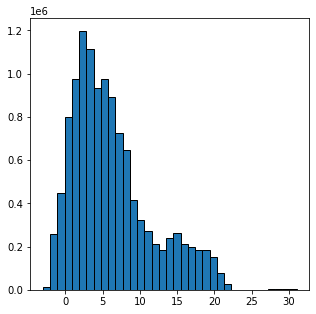

In [20]:
# ======== Visualising Data ===================
# Distribution of Delays
# Initialize layout
fig, ax = plt.subplots(figsize = (5, 5))

#plot
ax.hist(AircraftAge_Delays['AircraftAge'], bins = 35, edgecolor = "black")

We used the `.hist()` function to create a histogram to view the distribution of AircraftAge.

looking at the histogram, we can see that some planes have been classified as having negative age, this is impossible, but a possible reason that this happened is because the planes data frame contains planes from 2008 as well, therefore the tailnum of the planes with negative age could have been linked to newer planes. 

From the histogram, we can also see that after the age of 22, the number of planes still active drops off significantly.

#### Cleaning the AircraftAge_Delays Table

In [21]:
# ======= Cleaning Data ============
# Age cannot be negative so will be removing them as outliers, Planes above the age of 22 have significantly lesser flights, removed as noise
AircraftAge_Delays = AircraftAge_Delays.query("AircraftAge >= 0 & AircraftAge <= 22")

We cleaned the AircraftAge_Delays table by simply using the `.query()` function to filter out the outliers and noise.

#### Visualising the Cleaned AircraftAge_Delay Table

(array([ 800836.,  974527., 1197146., 1111967.,  935360.,  974585.,
         892284.,  724853.,  645578.,  416747.,  324515.,  271813.,
         209631.,  183697.,  238383.,  264639.,  212889.,  196380.,
         184296.,  182026.,  152235.,  104414.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22.]),
 <BarContainer object of 22 artists>)

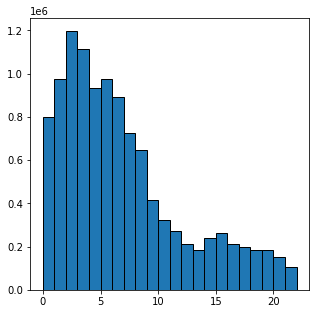

In [22]:
# ======== Visualising Data ===================
# Distribution of Delays
# Initialize layout
fig, ax = plt.subplots(figsize = (5, 5))

#plot
ax.hist(AircraftAge_Delays['AircraftAge'], bins = 22, edgecolor = "black")

Looking at the “cleaned” AircraftAge, we can see that we successfully removed the outliers and noise from the AircraftAge_Delay table.

We decided that conducting Pearson’s Correlation Analysis to identify the linear relationship of AircraftAge and the Average Arrival Delay will allow us to conclude that older planes suffer more delays.

#### Person's Correlation Analysis

The Correlation Analysis allows us to identify the linear relationship between 2 variables, if there is a positive correlation between the 2 variables it means that as one variable increases the other also increases, and if there is a negative correlation it means that as one variable increases the other decreases.

Using this we can find other whether as age increase will average arrival delay increase or not.

#### Preparing the table for Pearson’s Correlation

In [23]:
# ========== Finding the Probability of Delay ==============
# Grouping the data by AircraftAge
AircraftAge_Delays = AircraftAge_Delays.groupby(['AircraftAge'], as_index = False).agg({'ArrDelay': ['mean']})

# Calculating the ProbabilityofDelay
AircraftAge_Delays['AvgDelay'] = AircraftAge_Delays[('ArrDelay', 'mean')]

AircraftAge_Delays = AircraftAge_Delays[['AircraftAge', 'AvgDelay']]

AircraftAge_Delays

,AircraftAge,AvgDelay
,,
0,0,9.348290
1,1,9.517678
2,2,10.188116
3,3,10.929739
4,4,10.009602
5,5,8.570046
6,6,8.650072
7,7,9.362050
8,8,9.556162


To prepare the table for the correlation analysis, we first have to group the table using the `.groupby()` function to group the AircraftAge, then using `.agg()` and specifying `{'ArrDelay': ['mean']}` to derive the average arrival delay (AvgDelay).

#### Verifying Test Assumptions
Before conducting person’s correlation, there are some test assumptions we have to check.

1. Is there a Linear Relationship?
To visualize this we will be creating a regression plot using `.regplot()`

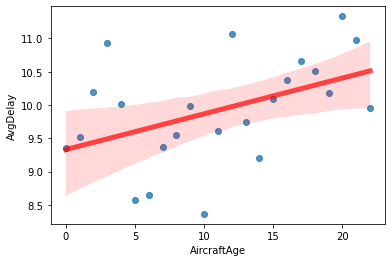

In [24]:
# ========== Visualizing Data ======================
sns.regplot(x = AircraftAge_Delays["AircraftAge"], y = AircraftAge_Delays["AvgDelay"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

Looking at the plot above, we can see that there seems to be a linear relationship between the 2 variables.

2. Does the 2 variables follow a normal distribution?

We will be conducting the Shapiro-Wilk normality test using `stats.shapiro()` to test normality of the 2 variables.

Normality Test Hypotheses:

$H_0$ : The data are normally distributed

$H_1$ : The data are not normally distributed

Setting a significance level of 5%, we will reject the null hypothesis if the p-value of the test is less than 0.05

In [25]:
# Normality Test for Aircraft Age
stats.shapiro(AircraftAge_Delays["AircraftAge"])

ShapiroResult(statistic=0.9591798186302185, pvalue=0.4470047652721405)

In [26]:
# Normality Test for Probability of Delay
stats.shapiro(AircraftAge_Delays["AvgDelay"])

ShapiroResult(statistic=0.9761690497398376, pvalue=0.8317636847496033)

Both p-values are greater than the significance level 0.05 implying that there is insufficient evidence at 5% significance level to conclude that the distribution of the data are significantly different from normal distribution. In other words, we can assume normality.

After verifying the test assumptions, we can proceed with increased confidence in the correlation test.

#### Pearson's Correlation Formula:

$$ r = \frac{\sum(x-m_{x})(y-m_y)}{(\sqrt{\sum(x-m_{x})^2\sum(y-m_y)^2}} $$

$m_{x}$ and $m_{y}$ are the means of x and y variables

The p-value (Significance Level) of the correlation is determined by looking at the corresponding p-value using the t-distribution table for $df = n - 2$

#### Correlation test hypotheses:

$H_0$ : AircraftAge and AvgDelay are not correlated

$H_1$ : AircraftAge and AvgDelay are correlated

Setting a significance level of 5%, we will reject the null hypothesis if the p-value of the test is less than 0.05

#### Results of Pearson's Correlation

Instead of calculating by hand, we can use the `scipy.stats.pearsonr()` function to tell python to conduct a Pearson's correlation analysis on the 2 variables.

In [27]:
# Correlation Test
cor = scipy.stats.pearsonr(AircraftAge_Delays["AircraftAge"], AircraftAge_Delays["AvgDelay"])

In [28]:
print("Corelation Coefficient is:", cor[0], " and p value is:", cor[1])

Corelation Coefficient is: 0.4543758982056738  and p value is: 0.029396908765657342


Since, p-value = 0.029 < 0.05, therefore, we can reject null hypothesis at 5% significance level, and conclude that age of the aircraft and average arrival delays is significantly correlated. With a correlation coeﬀicient of 0.45 shows that Age of Aircraft and the Probability of Delays have a medium positive linear relationship.

#### Result of Analysis
Since there is a medium positive correlation between AircraftAge and the AvgDelay, it is not unreasonable to assume that as Aircraft Age increases the Average Arrival Delay also increases, therefore, older planes do suffer more delays.

### Question 3

#### How does the number of people flying between different locations change over time?

To answer this question we will be analyzing the ontime table to visualize completed flights in the US over time.

#### Flights Table

In [29]:
# Creating the Flights table by analysing the ontime table
Flights = ontime[['Year', 'Month']]

# Grouping the data by Year and Month
Flights = Flights.groupby(['Year', 'Month'], as_index = False).size()

# Turn long format into a wide format
Flights_wide = Flights.pivot_table(index = 'Year', columns = 'Month', values = 'size')

Flights

,Year,Month,size
0,2006,1,570130
1,2006,2,518645
2,2006,3,596578
3,2006,4,577718
4,2006,5,594626
5,2006,6,586418
6,2006,7,608631
7,2006,8,617379
8,2006,9,573750
9,2006,10,599086


We created the Flights table from the Year and Month column in the ontime data frame, we then grouped the Flights table by Year and Month using the `.groupby()` function, and using `.size()` to derive the total flights in for each unique combination of Year and Month.

#### Visualizing the Flights Table
We believe visualizing the data as a heat map will allow us to see the difference in number of flights across the months and Year much more easier as compared to looking at numbers in its table form.

<AxesSubplot:xlabel='Month', ylabel='Year'>

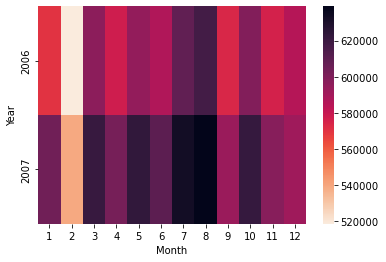

In [30]:
# ========== Visualizing Data ======================
sns.heatmap(Flights_wide, cmap = "rocket_r")

We created the heat map using `sns.heatmap()`, from the heat map, we can see that year on year 2007 is a shade darker as compared to 2006, we can also see patterns such as February having the least flights July-August having the most flights for both years. Therefore, we can say that flight patterns does not change much over the years just that year on year 2007 has more air traffic than 2006.

### Question 4

#### Can you detect cascading failures as delays in one airports create delays in others?

As stated in the question, cascaded failures means delays in one airport creating delays in others. Therefore, to answer this question we will have to identify the presence of cascaded delays, which we have defined as delays in the origin airport causing delay propagation to the destination airport.

Firstly, to answer this question we will have to identify Delay propagation(Propagated_Delay), we will use the data available in the ontime data frame for this analysis.

In [31]:
# ===== Forming the Propa_Delay table for analysis ======
# Propagated delays is when DepDelay in one airport causes ArrDelay at another
Cas_Delay = ontime.copy()

# Finding out which flights has Propagated Delays
def Propadelay(DepDelay, ArrDelay):
    if DepDelay > 0 and ArrDelay > 0:
        return 'Propagated'
    else:
        return 'Not Propagated'
        
PropaDelay_list = []

for DepDelay, ArrDelay in zip(Cas_Delay.DepDelay, Cas_Delay.ArrDelay):
    PropaDelay = Propadelay(DepDelay, ArrDelay)
    PropaDelay_list.append(PropaDelay)
    
Cas_Delay['PropagatedDelay'] = PropaDelay_list

Cas_Delay = Cas_Delay[['date', 'FlightNum', 'TailNum', 'Origin', 'CRSDepTime', 'DepTime', 'DepDelay', 'Dest', 'CRSArrTime', 'ArrTime', 'ArrDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay','PropagatedDelay']]

Cas_Delay

,date,FlightNum,TailNum,Origin,CRSDepTime,DepTime,DepDelay,Dest,CRSArrTime,ArrTime,ArrDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,PropagatedDelay
0,2006-01-11,343,N657AW,ATL,745,743.0,-2.0,PHX,1018,1024.0,6.0,0,0,0,0,0,Not Propagated
1,2006-01-11,613,N834AW,ATL,1053,1053.0,0.0,PHX,1318,1313.0,-5.0,0,0,0,0,0,Not Propagated
2,2006-01-11,617,N605AW,ATL,1915,1915.0,0.0,PHX,2133,2110.0,-23.0,0,0,0,0,0,Not Propagated
3,2006-01-11,300,N312AW,AUS,1755,1753.0,-2.0,PHX,1933,1925.0,-8.0,0,0,0,0,0,Not Propagated
4,2006-01-11,765,N309AW,AUS,832,824.0,-8.0,PHX,1015,1015.0,0.0,0,0,0,0,0,Not Propagated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7453210,2007-12-15,58,N670DN,MCO,1605,1558.0,-7.0,ATL,1736,1749.0,13.0,0,0,0,0,0,Not Propagated
7453211,2007-12-15,59,N829MH,ATL,1851,1902.0,11.0,SLC,2105,2110.0,5.0,0,0,0,0,0,Propagated
7453212,2007-12-15,61,N623DL,LAX,1025,1024.0,-1.0,ATL,1735,1750.0,15.0,0,0,15,0,0,Not Propagated
7453213,2007-12-15,62,N970DL,DFW,1315,1353.0,38.0,ATL,1622,1658.0,36.0,0,0,0,0,36,Propagated


The method `.copy()` is used here so that any changes made in new DataFrame don't get reflected in the original one.

Propagated Delays is detected by using the function `Propadelay(DepDelay, ArrDelay)` which uses a `if-else` statement that creates the categorical variable ‘Propagated’ when there is Departure Delay and Arrival Delay occurring on the same flight, and ‘Not Propagated’ when it does not occur. We then use the function inconjuction with a `for-loop` to loop through the entire table, to return a list that will be passed on to the PropagatedDelay column in the Cas_Delay table.

Now that we identified which flights has delay propagation, we will have to find out the relationship between delays in the origin airports and the propagation of delays to conclude whether delays in one airport causes delays in the next airport.

To identify the relationship between the delay attributes and delay propagation, we will conduct a chi-squared test for independence.

#### Chi-Square Test for independence

The chi-square test for independence tests for the relationship of the variables

#### Preparing the data for the chi-sqaure test

Chi-square test of independence requires categorical variables, we have already categorized the delay propagation, therefore, we will have to categorize the delay variables of the origin airport next.

In [32]:
# Identifying the delay variables
def DelayVariable(CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay):
    if CarrierDelay > 0 or WeatherDelay > 0 or NASDelay > 0 or SecurityDelay > 0 or LateAircraftDelay > 0:
        return 'Delayed'
    else:
        return 'Not Delayed'
        
Delay_Variable_list = []

for CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay in zip(Cas_Delay.CarrierDelay, Cas_Delay.WeatherDelay, Cas_Delay.NASDelay, Cas_Delay.SecurityDelay, Cas_Delay.LateAircraftDelay):
    delayvariable = DelayVariable(CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay)
    Delay_Variable_list.append(delayvariable)
    
Cas_Delay['Delay_Variable'] = Delay_Variable_list

The Delay_Variable column is derived by defining a function named `DelayVariable()` that returns a "Delayed" variable when either CarrierDelay > 0 or WeatherDelay > 0 or NASDelay > 0 or SecurityDelay > 0 or LateAircraftDelay > 0.

In [33]:
# create contingency table
data_crosstab = pd.crosstab(Cas_Delay['Delay_Variable'], Cas_Delay['PropagatedDelay'], margins=True, margins_name="Total")
data_crosstab

PropagatedDelay,Not Propagated,Propagated,Total
Delay_Variable,,,
Delayed,424901,2993956,3418857
Not Delayed,9211247,1648986,10860233
Total,9636148,4642942,14279090


Chi-square test will require the use of a contingency table, we will use the function `pd.crosstab()` to create one from the Cas_Delay table.

#### Chi-Square Test Formula:

Expected value is calculated by:
$$ e = \frac{row.sum∗col.sum}{grand.total} $$

Chi-square statistic is calculated as follows:

$$ \chi^2 = \sum\frac{(o-e)^2}{e}  $$ 

o is the observed value 

e is the expected value

#### Chi-squared test hypotheses:

$H_0$ : Delay_Variable and Propagated_Delay are independent. 

$H_1$ : Delay_Variable and Propagated_Delay are dependent

Setting a significance level of 5%, we will reject the null hypothesis if the p-value of the test is less than 0.05

#### Results of Chi-Squared Test

In [34]:
# Calcualtion of Chisquare test statistics
chi_square = 0
rows = Cas_Delay['Delay_Variable'].unique()
columns = Cas_Delay['PropagatedDelay'].unique()
for i in columns:
    for j in rows:
        O = data_crosstab[i][j]
        E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
        chi_square += (O-E)**2/E
        
p_value = 1 - stats.norm.cdf(chi_square, (len(rows)-1)*(len(columns)-1))

print("chisquare-score is:", chi_square, " and p value is:", p_value)

chisquare-score is: 6209528.758578311  and p value is: 0.0


Since, p-value < 0.05, we will reject the null hypothesis at 5% significance level, and conclude that there is a relationship between between Propagated Delays and the Delay_Variables.

However, it must be noted that even though there is a relationship between Propagated Delays and the Delay Variables, it does not mean that the delay variables causes the delay propagation, as there could be multitudes of other reasons delays are being cascaded, such as the type of airport, type of plane etc. 

Therefore, just by looking at delays, we cannot conclude that we can detect cascading failures.

### Question 5

#### Use the available variables to construct a model that predicts delays

We will be using the variables from the ontime data frame to predict Arrival Delays (ArrDelay)

#### Preparing the Predictors and predicted value

The predictors are namely the attributes Season, Day, TimeofDay, DepDelay, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay and LateAircraftDelay, while the outcome variable is in the Delayed column.

We did not select AircraftAge as Predictor as it tends to cause python to crash, so to prevent crashing we will not use it as a predictor, but it may be noted that it may be a good predictor for ArrDelay.

In [35]:
# Identifying the predictors
Delay_Prediction = ontime[['Season', 'Day', 'TimeofDay', 'DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Delayed']]
Delay_Prediction

,Season,Day,TimeofDay,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Delayed
0,Winter,Wednesday,Morning,-2.0,0,0,0,0,0,1
1,Winter,Wednesday,Morning,0.0,0,0,0,0,0,0
2,Winter,Wednesday,Evening,0.0,0,0,0,0,0,0
3,Winter,Wednesday,Evening,-2.0,0,0,0,0,0,0
4,Winter,Wednesday,Morning,-8.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
7453210,Winter,Saturday,Afternoon,-7.0,0,0,0,0,0,1
7453211,Winter,Saturday,Evening,11.0,0,0,0,0,0,1
7453212,Winter,Saturday,Morning,-1.0,0,0,15,0,0,1
7453213,Winter,Saturday,Afternoon,38.0,0,0,0,0,36,1


In [36]:
Delay_Prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14279090 entries, 0 to 7453214
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Season             object 
 1   Day                object 
 2   TimeofDay          object 
 3   DepDelay           float64
 4   CarrierDelay       int64  
 5   WeatherDelay       int64  
 6   NASDelay           int64  
 7   SecurityDelay      int64  
 8   LateAircraftDelay  int64  
 9   Delayed            int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 1.2+ GB


We can see that some of the variables are still formatted as objects. But we can see that the predictors are a mix of categorical and continuous data. Therefore, it makes sense to use logistic regression to create a prediction model.

#### Preparing the data for Logistic Regression

We will convert all catergorical columns to dummy variables using the following process

In [37]:
categorical_features = Delay_Prediction[['Season', 'Day', 'TimeofDay']]
categorical_features

,Season,Day,TimeofDay
0,Winter,Wednesday,Morning
1,Winter,Wednesday,Morning
2,Winter,Wednesday,Evening
3,Winter,Wednesday,Evening
4,Winter,Wednesday,Morning
...,...,...,...
7453210,Winter,Saturday,Afternoon
7453211,Winter,Saturday,Evening
7453212,Winter,Saturday,Morning
7453213,Winter,Saturday,Afternoon


We seperated the categorical variables away from the Delay_Prediction Table for easier manipulation.

In [38]:
# Season
Season = pd.get_dummies(categorical_features['Season'], drop_first = True)

# Day
Day = pd.get_dummies(categorical_features['Day'], drop_first = True)

# TimeofDay 
TimeofDay = pd.get_dummies(categorical_features['TimeofDay'], drop_first = True)

# Drop columns that are going to be replaced with dummy variables
categorical_features.drop(['Season', 'Day', 'TimeofDay'], axis = 1, inplace = True)

# Add in dummy variables columns
categorical_features = pd.concat([Season, Day, TimeofDay], axis = 1)

categorical_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14279090 entries, 0 to 7453214
Data columns (total 12 columns):
 #   Column     Dtype
---  ------     -----
 0   Spring     uint8
 1   Summer     uint8
 2   Winter     uint8
 3   Monday     uint8
 4   Saturday   uint8
 5   Sunday     uint8
 6   Thursday   uint8
 7   Tuesday    uint8
 8   Wednesday  uint8
 9   Evening    uint8
 10  Morning    uint8
 11  Night      uint8
dtypes: uint8(12)
memory usage: 272.4 MB


We have to change the categorical variables to a format that the Linear Regression model will understand, therefore, we will have to use dummy variables on our categorical variables, we can do this easily by employing the use of `pd.get_dummies()`.

In [39]:
# Combining the categorical and numerical features into features
numerical_features = Delay_Prediction[['DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].copy()

features = pd.concat([categorical_features, numerical_features], axis=1)

features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14279090 entries, 0 to 7453214
Data columns (total 18 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Spring             uint8  
 1   Summer             uint8  
 2   Winter             uint8  
 3   Monday             uint8  
 4   Saturday           uint8  
 5   Sunday             uint8  
 6   Thursday           uint8  
 7   Tuesday            uint8  
 8   Wednesday          uint8  
 9   Evening            uint8  
 10  Morning            uint8  
 11  Night              uint8  
 12  DepDelay           float64
 13  CarrierDelay       int64  
 14  WeatherDelay       int64  
 15  NASDelay           int64  
 16  SecurityDelay      int64  
 17  LateAircraftDelay  int64  
dtypes: float64(1), int64(5), uint8(12)
memory usage: 926.0 MB


In [40]:
# Predictors and Predicted variables
X = features.copy()
y = Delay_Prediction['Delayed'].copy()

#### Logistic Regression

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (Arrival Delay) or 0 (No Arrival Delay). In other words, the logistic regression model predicts P(Y=1) as a function of X.

#### Training and Testing data sets (80% Training, 20% Test)

In [41]:
# Split the data into training (80%) and test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 1)

#### Extend the results: Logistic Regression

Using the `LogisticRegression()` function imported from the `sklearn.linear_model` package we can create a Logistic Regression classifier object, we then, fit the model on the train data set using `.fit()` and perform prediction on the test set using `.predict()`.

In [42]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

# making predictions
y_pred = logreg.predict(X_test)

#### Model Evaluation

The model accuracy is evaluated using a confusion matrix.

The confusion matrix is created by first creating a contingency table using the `metrics.confusion_matrix` function holding the values of y_test, y_pred.

In [43]:
# Confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1444768,   81249],
       [ 435313,  894488]])

Text(0.5, 257.44, 'Predicted Arrival Delay')

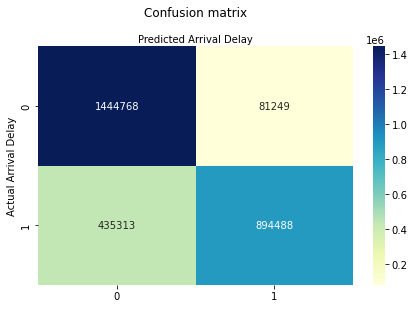

In [44]:
# Visualising Confusion Matrix
class_names = [0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "YlGnBu", fmt = 'd')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual Arrival Delay')
plt.xlabel('Predicted Arrival Delay')

In [45]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8191194256776867
Precision: 0.916730635406877
Recall: 0.6726480127477721


Looking at the confusion matrix, we can see that the logistic regression model correctly predicted 894,488 “Arrival Delay” and 1,444,768 “No Arrival Delay”, and only wrongly predicted 81,249 “Arrival Delay” and 435,313 “No Arrival Delay”. This gives us a accuracy rating of 81.9%.

#### Plotting ROC Curve

We will be using a ROC Curve to further evaluate our prediction model, Area under ROC curve (AUC) is often used as a measure of quality of the classification models. A random classifier has an area under the curve of 0.5, while AUC for a perfect classifier is equal to 1.

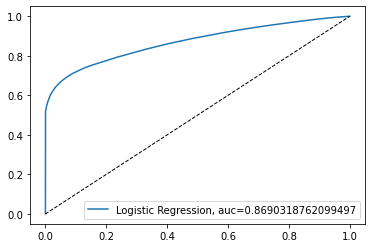

In [46]:
# ROC Curve
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label = "Logistic Regression, auc=" + str(auc))
plt.legend(loc = 4)
plt.plot([0, 1], [0, 1], color = 'black', lw = 1, linestyle = '--')
plt.show()

#### Prediction Model Effectiveness

The model has a accuracy level of 81.9% in predicting Arrival Delays. Given if the 2 groups are of equal size, by chance alone, one will expect a hit ratio of 50%, thus, since there is an improvement over chance of more than 25%, it indicates satisfactory validity. This result is further backed by the 0.87 AUC value returned by the model, which shows that it is a strong classifier of Arrival Delays.

## References

Brownlee, J. (2020, August 20). How to calculate correlation between variables in Python. Machine Learning Mastery. Retrieved February 3, 2022, 
from https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/
    
De-Yu, C. (2022, January 14). Chi-square test, with python. Medium. Retrieved February 3, 2022, 
from https://towardsdatascience.com/chi-square-test-with-python-d8ba98117626 
    
Scipy.stats.shapiro. scipy.stats.shapiro - SciPy v1.7.1 Manual. (n.d.). Retrieved February 3, 2022, 
from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html 
    
Navlani, A. (2019, December 17). Python logistic regression tutorial with Sklearn &amp; Scikit. DataCamp Community. Retrieved March 4, 2022, from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python 

Curry, R. (2021, October 25). Simplified logistic regression: Classification with categorical variables in Python. Medium. Retrieved March 4, 2022, from https://medium.com/@curryrowan/simplified-logistic-regression-classification-with-categorical-variables-in-python-1ce50c4b137 